In [2]:
import numpy as np
import pandas as pd
import pickle

import features

BeautifulSoup not found


c:\Users\TODYAS\miniforge3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch and torchvision not found


In [3]:
test = pd.read_csv("data/test.csv")

In [4]:
test["text"] = test["text"].fillna("")

In [5]:
# Load saved artifacts (must match fit.ipynb - image_backbone only if use_image_embeddings=True)
text_embedder = features.load_text_embedder("text_embedder")

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 810.91it/s, Materializing param=pooler.dense.weight]                               


In [6]:
# Build features - flags must match training (fit.ipynb)
X, _ = features.build_features(
    test,
    text_embedder=text_embedder,
    use_text_embeddings=True,
    use_text_handcrafted=True,
    use_image_embeddings=False,
    use_image_handcrafted=False,
)

Batches: 100%|██████████| 111/111 [00:26<00:00,  4.18it/s]


In [7]:
print("Feature shape:", X.shape)

Feature shape: (3527, 390)


In [8]:
# X built in cell 4

In [9]:
# (X from build_features)

In [10]:
target = ["like", "comment", "hide", "expand", "open_photo", "open", "share_to_message"]

In [11]:
# Add test identifiers (from head.txt: train has view,like,...,text,photo; test has view,text,photo)
submission = test[["view"]].copy()
submission["id"] = np.arange(len(test))
prediction = pd.DataFrame()

In [12]:
with open('model.pickle', 'rb') as f:
    model = pickle.load(f)

In [13]:
for column in target:
    reg = model[column]
    y = reg.predict(X)
    prediction[column] = y * test['view']

submission = pd.concat([submission[["id", "view"]], prediction], axis=1) 


In [14]:
prediction

,like,comment,hide,expand,open_photo,open,share_to_message
0,3.337095,0.427789,0.781448,203.146839,78.184874,34.753477,5.385729
1,5.131709,1.156806,0.324806,323.722138,114.707765,119.018983,2.612734
2,76.732058,8.252249,4.943129,1599.248750,509.677203,254.756038,16.608891
3,16.842470,2.388909,1.527940,329.028277,19.269621,123.186306,14.467498
4,165.148514,5.573276,3.258423,-15.257877,146.252768,57.725734,24.636861
...,...,...,...,...,...,...,...
3522,296.936181,3.889001,4.083103,-0.831613,283.101006,55.994360,35.802245
3523,260.671860,3.414043,3.584441,-0.730050,248.526352,49.155862,31.429777
3524,10.020840,0.670448,0.432326,343.491559,19.049522,21.281579,1.424162
3525,52.902638,2.025849,3.799752,472.338064,159.374453,460.150365,19.749547


In [15]:
submission.to_csv("submission.csv", index=False)

In [31]:
# Feature importance and correlations analysis
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Build feature names (must match build_features order: text_emb 384 + handcrafted 6)
n_text_emb = 384  # paraphrase-multilingual-MiniLM-L12-v2
feat_names = [f"text_emb_{i}" for i in range(n_text_emb)]
feat_names += ["text_len", "word_count", "emoji_count", "has_links", "br_count", "html_clean_len"]
assert len(feat_names) == X.shape[1], f"Feature count mismatch: {len(feat_names)} vs {X.shape[1]}"

In [32]:
# --- Feature importance ---
# CatBoostRegressor exposes feature_importances_ (and get_feature_importances)
fi_dfs = {}
for col in target:
    reg = model[col]
    fi = reg.feature_importances_
    fi_dfs[col] = pd.Series(fi, index=feat_names).sort_values(ascending=False)

# Top-15 most important features per target
for col in target:
    print(f"\n--- {col} (top 15) ---")
    print(fi_dfs[col].head(15).to_string())


--- like (top 15) ---
html_clean_len    1.882530
text_emb_337      1.654441
text_emb_35       1.505160
text_emb_380      1.427718
text_emb_360      1.389029
text_emb_99       1.275270
text_len          1.154540
text_emb_347      1.108133
word_count        1.105832
text_emb_274      1.065593
text_emb_249      0.990781
text_emb_363      0.946199
text_emb_20       0.895958
text_emb_62       0.832240
text_emb_383      0.830902

--- comment (top 15) ---
text_emb_67     5.208116
text_emb_208    4.218700
text_emb_224    3.025081
text_emb_325    3.000265
text_emb_184    2.750120
text_emb_94     2.257203
text_emb_98     2.183069
text_emb_202    1.819091
text_emb_250    1.764936
emoji_count     1.660572
text_emb_103    1.371061
text_emb_314    1.358595
text_emb_68     1.266812
text_emb_212    1.239052
text_emb_291    1.189300

--- hide (top 15) ---
text_emb_196    12.423013
text_emb_149     7.588896
text_emb_56      2.524351
text_emb_245     1.602895
text_emb_14      1.586844
text_emb_102     1

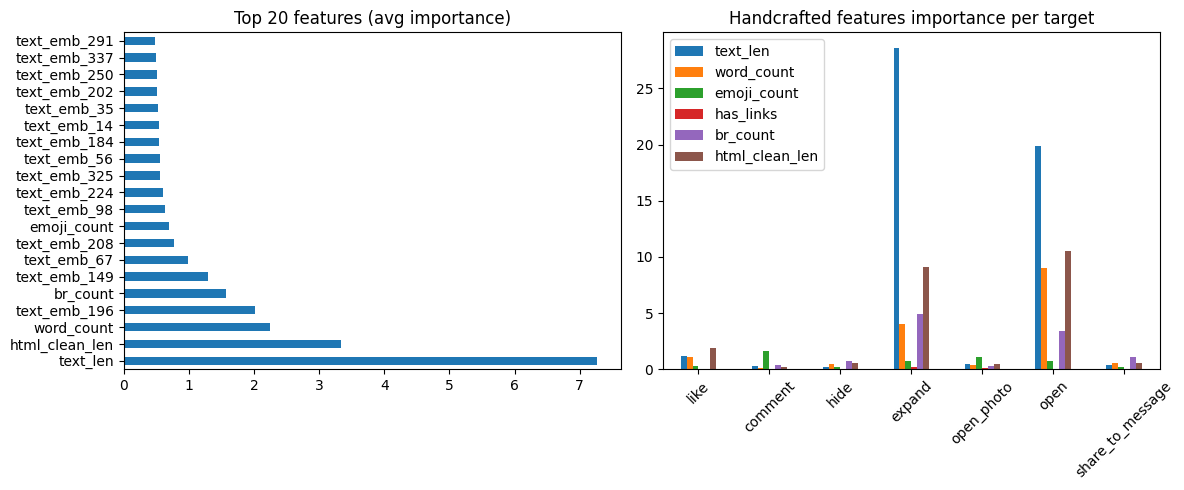

In [33]:
# Aggregated feature importance (mean across targets) and handcrafted-only view
fi_agg = pd.concat(fi_dfs, axis=1).mean(axis=1).sort_values(ascending=False)
hc_names = ["text_len", "word_count", "emoji_count", "has_links", "br_count", "html_clean_len"]
fi_hc = pd.DataFrame({col: fi_dfs[col].reindex(hc_names) for col in target})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fi_agg.head(20).plot(kind="barh", ax=axes[0], title="Top 20 features (avg importance)")
fi_hc.T.plot(kind="bar", ax=axes[1], title="Handcrafted features importance per target", rot=45)
plt.tight_layout()
plt.show()

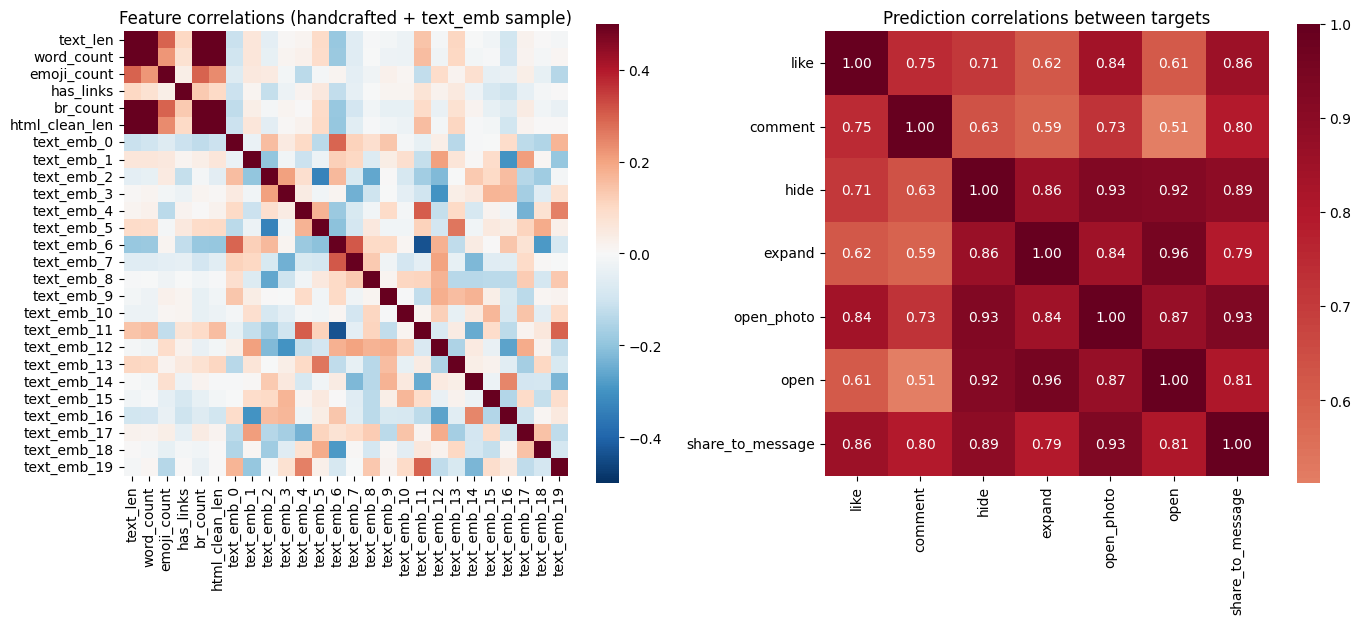

In [34]:
# --- Correlations ---
# 1) Feature correlation matrix (handcrafted + sample of embedding dims for readability)
hc_idx = [feat_names.index(n) for n in hc_names]
emb_sample_idx = list(range(0, min(20, n_text_emb)))  # first 20 embedding dims
corr_idx = hc_idx + [feat_names.index(f"text_emb_{i}") for i in emb_sample_idx]
X_sub = pd.DataFrame(X[:, corr_idx], columns=[feat_names[i] for i in corr_idx])
corr_features = X_sub.corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(corr_features, ax=axes[0], cmap="RdBu_r", center=0, vmin=-0.5, vmax=0.5, square=True)
axes[0].set_title("Feature correlations (handcrafted + text_emb sample)")

# 2) Prediction correlations between targets
corr_pred = prediction.corr()
sns.heatmap(corr_pred, ax=axes[1], cmap="RdBu_r", center=0, annot=True, fmt=".2f", square=True)
axes[1].set_title("Prediction correlations between targets")
plt.tight_layout()
plt.show()

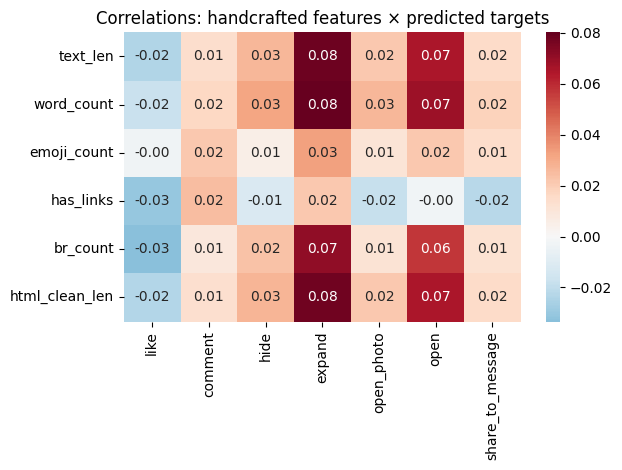

In [35]:
# 3) Feature–prediction correlations (handcrafted features vs predicted targets)
X_hc = pd.DataFrame(X[:, hc_idx], columns=hc_names)
combined = pd.concat([X_hc, prediction], axis=1)
corr_feat_pred = combined.corr().loc[hc_names, target]
sns.heatmap(corr_feat_pred, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Correlations: handcrafted features × predicted targets")
plt.tight_layout()
plt.show()